In [1]:
# -*- coding: utf-8 -*-

import glob
import pandas as pd
import datetime as dt
import numpy as np
def gdal_corners(filename):
    '''
    a function  that can be used to determine the boundary of a raster / tif file.
    '''
    #http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    from osgeo import gdal            # https://www.lfd.uci.edu/~gohlke/pythonlibs/
    ds = gdal.Open(filename)
    width = ds.RasterXSize
    height = ds.RasterYSize
    gt = ds.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    return (minx,miny,maxx,maxy)

def time_series_swsr_xarray(file_list, meta_dic):
    
    '''
        a method for merging raster/tif data along the band dimension using 
        rioxarray. this method does not save data to storage.
    '''
    
    import rioxarray as rxr
    import xarray as xr
    
    # loop over bands, append to a rasterio xarray
    for file, i in zip(file_list, range(len(file_list)) ):
        
        xmin,ymin,xmax,ymax=tuple(gdal_corners(file))
        cda=rxr.open_rasterio(file,chunks=(1,2000,2000))
        cda=cda.sel(x=slice(xmin,xmax),y=slice(ymax,ymin))
        cda = cda.where(cda != 0, np.nan)
        
        for cur_key in meta_dic.keys():
            if cur_key != 'ids':
                cda[cur_key] = meta_dic[cur_key][i]
        # cda['fn'] = fn
        # cda['times'] = t
        
        if file == file_list[0]:
            da = cda
        else:
            da = xr.concat([da, cda], "band")  

    # change band names for reading
    # da = da.assign_coords({'band' : meta_dic['ids']})
    # Change band names for Michelle's interpretation
    da = da.assign_coords({'band' : meta_dic['time']})
    return da

fn_loc = '/home/jovyan/shared-public/swesarr_project/swesarr-radar/'
res = glob.glob(fn_loc + "v3_tifs/*.tif")
res
res = [a.replace('\\','/') for a in res]
fns = [a.split('/')[-1] for a in res]
ids = ['_'.join( [a.split('_')[2], a.split('_')[3]] ) for a in fns]
times = pd.read_csv(fn_loc + "v3_tifs/swesarr_time_table.csv")

swsr_dt = [a + ' ' + b for a,b in zip( times['Start_Date_UTC'], times['Start_Time_UTC'])]
str_blrb = "%m/%d/%Y %H:%M:%S"
swsr_dts = [dt.datetime.strptime(a, str_blrb) for a in swsr_dt]

data_tag_time = ['_'.join( a.split('_')[2:4] ) for a in times['Folder']]
tmp_pd = pd.DataFrame( {'id' : data_tag_time} )
tmp_v = [tmp_pd[tmp_pd == a].dropna().index[0] for a in ids]
swsr_dts = [swsr_dts[a] for a in tmp_v]

meta_labs = ['file_name', 'ids', 'times']
meta_vals = [fns, ids, swsr_dts]
meta_dic = {'file_name' : fns, 'ids' : ids, 'time' : swsr_dts}

out = time_series_swsr_xarray(res, meta_dic)

/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [2]:
out.band

<xarray.DataArray 'band' (band: 14)> Size: 112B
array(['2019-11-06T15:23:09.000000000', '2019-11-06T16:02:53.000000000',
       '2020-02-11T17:50:04.000000000', '2019-11-05T16:06:44.000000000',
       '2019-11-06T14:42:19.000000000', '2020-02-11T17:25:18.000000000',
       '2019-11-04T15:32:05.000000000', '2020-02-11T17:01:08.000000000',
       '2019-11-05T14:52:06.000000000', '2020-02-12T19:26:28.000000000',
       '2019-11-05T15:31:57.000000000', '2020-02-12T18:38:38.000000000',
       '2019-11-04T16:08:21.000000000', '2020-02-12T19:02:37.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
    file_name    (band) <U47 3kB 'GRMST1_27402_19005_014_191106_09225VV_XX_01...
    time         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...
  * band         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...

In [3]:
out.time

<xarray.DataArray 'time' (band: 14)> Size: 112B
array(['2019-11-06T15:23:09.000000000', '2019-11-06T16:02:53.000000000',
       '2020-02-11T17:50:04.000000000', '2019-11-05T16:06:44.000000000',
       '2019-11-06T14:42:19.000000000', '2020-02-11T17:25:18.000000000',
       '2019-11-04T15:32:05.000000000', '2020-02-11T17:01:08.000000000',
       '2019-11-05T14:52:06.000000000', '2020-02-12T19:26:28.000000000',
       '2019-11-05T15:31:57.000000000', '2020-02-12T18:38:38.000000000',
       '2019-11-04T16:08:21.000000000', '2020-02-12T19:02:37.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
    file_name    (band) <U47 3kB 'GRMST1_27402_19005_014_191106_09225VV_XX_01...
    time         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...
  * band         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...

In [4]:
res

['/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27402_19005_014_191106_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27403_19005_020_191106_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27503_20007_012_200211_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27403_19004_017_191105_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27401_19005_008_191106_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27702_20007_009_200211_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27401_19003_007_191104_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27401_20007_005_200211_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_ti

In [5]:
from shapely import speedups      # https://www.lfd.uci.edu/~gohlke/pythonlibs/
#speedups.disable()                # <-- handle a potential error in cartopy

import requests                   # !conda install -c anaconda requests 

# raster manipulation libraries
import rasterio                   # https://www.lfd.uci.edu/~gohlke/pythonlibs/
from osgeo import gdal            # https://www.lfd.uci.edu/~gohlke/pythonlibs/
import cartopy.crs as ccrs        # https://www.lfd.uci.edu/~gohlke/pythonlibs/
import rioxarray as rxr           # !conda install -c conda-forge rioxarray
import xarray as xr               # !conda install -c conda-forge xarray dask netCDF4 bottleneck

# SnowEx Pit Data!
from snowexsql.api import LayerMeasurements # pip install snowexsql

# plotting tools
from matplotlib import pyplot     # !conda install matplotlib
import datashader as ds           # https://www.lfd.uci.edu/~gohlke/pythonlibs/
import hvplot.xarray              # !conda install hvplot
import hvplot.pandas
import holoviews as hv

# append the subfolders of the current working directory to pythons path
import os, sys, glob

swesarr_subdirs = ["data", "util"]
tmp = [sys.path.append(os.getcwd() + "/" + sd) for sd in swesarr_subdirs]
del tmp # suppress Jupyter notebook output, delete variable

# lambda functions! <<< HERE!!!
to_nl = lambda a: 10**(a/10)
to_db = lambda a: 10*np.log10(a)

# settings to make matplotlib look nicer!
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 4.5) # (w, h)

#############################################
# Suppress Warnings for Cleaner Output      #
# (Address Warnings in future update)       #
import warnings                             #
warnings.filterwarnings('ignore')           #
#############################################

from helper import get_out_dir, gdal_corners, join_files, join_sar_radiom, filt_pit_to_sar, filt_radiom_points, sar_swe_plot, radiom_swe_plot, rough_radiom_area

ModuleNotFoundError: No module named 'helper'

In [ ]:
# Set clim directly:
clim=(-25, -5)
cmap='gray'
crs = ccrs.UTM(zone='12') #12n
tiles='OSM'
tiles='EsriImagery'
transparent_tile = hv.Tiles('https://server.arcgisonline.com/ArcGIS/rest/services/Reference/World_Reference_Overlay/MapServer/tile/{Z}/{Y}/{X}', name="EsriReference").opts(alpha=0.0)
frame_width  = 800
frame_height = 500

# create an image for SAR data!
sar_img = out.hvplot.image(x='x',y='y',groupby='band',cmap=cmap,clim=clim,rasterize=True,
                       xlabel='Longitude',ylabel='Latitude',
                       frame_height=frame_height, frame_width=frame_width,
                       xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.8)

sar_img

In [6]:
out

<xarray.DataArray (band: 14, y: 4031, x: 4931)> Size: 1GB
dask.array<concatenate, shape=(14, 4031, 4931), dtype=float32, chunksize=(1, 300, 248), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 39kB 7.388e+05 7.388e+05 ... 7.437e+05 7.437e+05
  * y            (y) float64 32kB 4.32e+06 4.32e+06 ... 4.324e+06 4.324e+06
    spatial_ref  int64 8B 0
    file_name    (band) <U47 3kB 'GRMST1_27402_19005_014_191106_09225VV_XX_01...
    time         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...
  * band         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...
Attributes:
    TIFFTAG_SOFTWARE:  Created with GAMMA Software www.gamma-rs.ch data2geoti...
    TIFFTAG_DATETIME:  2024:06:06 09:21:02
    AREA_OR_POINT:     Point
    _FillValue:        0.0
    scale_factor:      1.0
    add_offset:        0.0

In [7]:
out.time

<xarray.DataArray 'time' (band: 14)> Size: 112B
array(['2019-11-06T15:23:09.000000000', '2019-11-06T16:02:53.000000000',
       '2020-02-11T17:50:04.000000000', '2019-11-05T16:06:44.000000000',
       '2019-11-06T14:42:19.000000000', '2020-02-11T17:25:18.000000000',
       '2019-11-04T15:32:05.000000000', '2020-02-11T17:01:08.000000000',
       '2019-11-05T14:52:06.000000000', '2020-02-12T19:26:28.000000000',
       '2019-11-05T15:31:57.000000000', '2020-02-12T18:38:38.000000000',
       '2019-11-04T16:08:21.000000000', '2020-02-12T19:02:37.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
    file_name    (band) <U47 3kB 'GRMST1_27402_19005_014_191106_09225VV_XX_01...
    time         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...
  * band         (band) datetime64[ns] 112B 2019-11-06T15:23:09 ... 2020-02-1...

In [ ]:
# drop all the nans, there are too many
out = out.dropna(dim="x", how="all")
out = out.dropna(dim="y", how="all")
out

In [10]:
def npdt_tostr(dt):
    ts = pd.to_datetime(str(dt)) 
    d = ts.strftime('%Y%m%d')
    return(d)

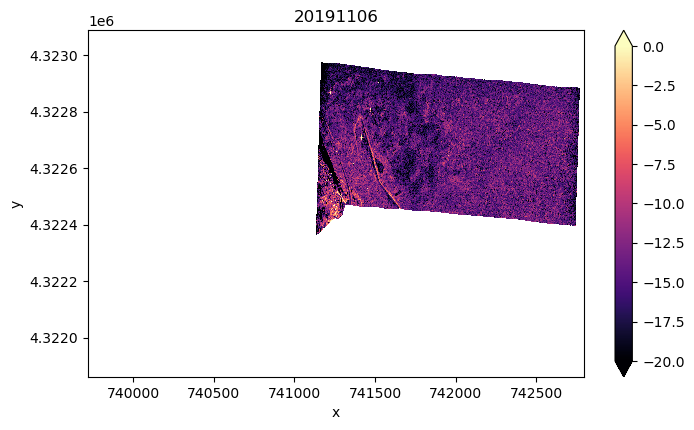

In [11]:
cmap = 'magma'
vmin = -20
vmax = 0
title_dt = npdt_tostr(out[0,:,:].time.values)
out[0,:,:].plot.imshow(cmap=cmap, vmin=vmin, vmax=vmax);
ax = plt.gca()
ax.set_title(title_dt);

In [12]:
# Linearize all values from dB
out = to_nl(out)

# How do autumn bits vary?

In [13]:
# Grab autumn bits only
autumn_chunk = out[out.time<pd.to_datetime('2020-01-01', format='%Y-%m-%d')]
autumn_chunk

<xarray.DataArray (band: 8, y: 1226, x: 3075)> Size: 121MB
dask.array<getitem, shape=(8, 1226, 3075), dtype=float32, chunksize=(1, 161, 126), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 25kB 7.397e+05 7.397e+05 ... 7.428e+05 7.428e+05
  * y            (y) float64 10kB 4.322e+06 4.322e+06 ... 4.323e+06 4.323e+06
    spatial_ref  int64 8B 0
    file_name    (band) <U47 2kB 'GRMST1_27402_19005_014_191106_09225VV_XX_01...
    time         (band) datetime64[ns] 64B 2019-11-06T15:23:09 ... 2019-11-04...
  * band         (band) datetime64[ns] 64B 2019-11-06T15:23:09 ... 2019-11-04...

In [14]:
# %%time
# # Linearize all values from dB
# autumn_chunk = to_nl(autumn_chunk)

In [15]:
# # drop all the nans, there are too many
# autumn_chunk = autumn_chunk.dropna(dim="y", how="all")
# autumn_chunk

In [16]:
# # drop all the nans, there are too many
# autumn_chunk = autumn_chunk.dropna(dim="x", how="all")
# autumn_chunk

In [17]:
clim=(0, 1e-1)

In [18]:
autumn_img = autumn_chunk.hvplot(clim=clim, rasterize=True, x='x', y='y', 
                                 xlabel='Longitude',ylabel='Latitude', groupby='band', 
                                 frame_height=frame_height, frame_width=frame_width,
                                 xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.8)
autumn_img

:DynamicMap   [band]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

In [19]:
%%time
autumn_median = np.nanmedian(autumn_chunk, axis=0)

CPU times: user 11.7 s, sys: 969 ms, total: 12.6 s
Wall time: 8.39 s


In [20]:
# Compute diffs from median
diff_clim = (-0.1, 0.1)
autumn_diffs = (autumn_chunk - autumn_median).hvplot(clim=diff_clim, rasterize=True, x='x', y='y', 
                                              xlabel='Longitude',ylabel='Latitude', groupby='band', 
                                              frame_height=frame_height, frame_width=frame_width, cmap='RdYlBu',
                                              xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.8,)
autumn_diffs

:DynamicMap   [band]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

In [21]:
autumn_chunk.time

<xarray.DataArray 'time' (band: 8)> Size: 64B
array(['2019-11-06T15:23:09.000000000', '2019-11-06T16:02:53.000000000',
       '2019-11-05T16:06:44.000000000', '2019-11-06T14:42:19.000000000',
       '2019-11-04T15:32:05.000000000', '2019-11-05T14:52:06.000000000',
       '2019-11-05T15:31:57.000000000', '2019-11-04T16:08:21.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
    file_name    (band) <U47 2kB 'GRMST1_27402_19005_014_191106_09225VV_XX_01...
    time         (band) datetime64[ns] 64B 2019-11-06T15:23:09 ... 2019-11-04...
  * band         (band) datetime64[ns] 64B 2019-11-06T15:23:09 ... 2019-11-04...

In [22]:
# Compute diffs from the earliest time stamp (index 4)
diff_clim = (-0.1, 0.1)
autumn_diffs = (autumn_chunk - autumn_chunk[4,:,:]).hvplot(clim=diff_clim, rasterize=True, x='x', y='y', 
                                                           xlabel='Longitude',ylabel='Latitude', groupby='band', 
                                                           frame_height=frame_height, frame_width=frame_width, cmap='RdYlBu',
                                                           xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.6,)
autumn_diffs

:DynamicMap   [band]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

In [23]:
# Grab winter bits only
winter_chunk = out[out.time>pd.to_datetime('2020-01-01', format='%Y-%m-%d')]
winter_chunk

<xarray.DataArray (band: 6, y: 1226, x: 3075)> Size: 90MB
dask.array<getitem, shape=(6, 1226, 3075), dtype=float32, chunksize=(1, 161, 126), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 25kB 7.397e+05 7.397e+05 ... 7.428e+05 7.428e+05
  * y            (y) float64 10kB 4.322e+06 4.322e+06 ... 4.323e+06 4.323e+06
    spatial_ref  int64 8B 0
    file_name    (band) <U47 1kB 'GRMST1_27503_20007_012_200211_09225VV_XX_01...
    time         (band) datetime64[ns] 48B 2020-02-11T17:50:04 ... 2020-02-12...
  * band         (band) datetime64[ns] 48B 2020-02-11T17:50:04 ... 2020-02-12...

In [24]:
%%time
winter_median = np.nanmedian(winter_chunk, axis=0)

CPU times: user 7.19 s, sys: 705 ms, total: 7.9 s
Wall time: 5.39 s


In [25]:
# Compute diffs from the median
diff_clim = (-0.1, 0.1)
winter_diffs = (winter_chunk - winter_median).hvplot(clim=diff_clim, rasterize=True, x='x', y='y', 
                                                           xlabel='Longitude',ylabel='Latitude', groupby='band', 
                                                           frame_height=frame_height, frame_width=frame_width, cmap='RdYlBu',
                                                           xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.6,)
winter_diffs

:DynamicMap   [band]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

In [26]:
winter_chunk.time

<xarray.DataArray 'time' (band: 6)> Size: 48B
array(['2020-02-11T17:50:04.000000000', '2020-02-11T17:25:18.000000000',
       '2020-02-11T17:01:08.000000000', '2020-02-12T19:26:28.000000000',
       '2020-02-12T18:38:38.000000000', '2020-02-12T19:02:37.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
    file_name    (band) <U47 1kB 'GRMST1_27503_20007_012_200211_09225VV_XX_01...
    time         (band) datetime64[ns] 48B 2020-02-11T17:50:04 ... 2020-02-12...
  * band         (band) datetime64[ns] 48B 2020-02-11T17:50:04 ... 2020-02-12...

In [27]:
# Compute diffs from the earliest time stamp (index 4)
diff_clim = (-0.1, 0.1)
winter_diffs = (winter_chunk - winter_chunk[2,:,:]).hvplot(clim=diff_clim, rasterize=True, x='x', y='y', 
                                                           xlabel='Longitude',ylabel='Latitude', groupby='band', 
                                                           frame_height=frame_height, frame_width=frame_width, cmap='RdYlBu',
                                                           xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.6,)
winter_diffs

:DynamicMap   [band]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

## compute ratio from earliest time stamp

In [ ]:
# Compute diffs from the earliest time stamp (index 4)
diff_clim = (0.5, 1.5)
winter_diffs = (winter_chunk / winter_chunk[2,:,:]).hvplot(clim=diff_clim, rasterize=True, x='x', y='y', 
# winter_diffs = (winter_chunk / winter_chunk[2,:,:]).hvplot(rasterize=True, x='x', y='y',                                                            
                                                           xlabel='Longitude',ylabel='Latitude', groupby='band', 
                                                           frame_height=frame_height, frame_width=frame_width, cmap='BrBG',
                                                           xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.7,)
winter_diffs

In [ ]:
# Compute diffs from the earliest time stamp (index 4)
diff_clim = (0.5, 1.5)
autumn_diffs = (autumn_chunk / autumn_chunk[4,:,:]).hvplot(clim=diff_clim, rasterize=True, x='x', y='y', 
# winter_diffs = (winter_chunk / winter_chunk[2,:,:]).hvplot(rasterize=True, x='x', y='y',                                                            
                                                           xlabel='Longitude',ylabel='Latitude', groupby='band', 
                                                           frame_height=frame_height, frame_width=frame_width, cmap='PuOr',
                                                           xformatter='%.1f',yformatter='%.1f', crs=crs, tiles=tiles, alpha=0.7,)
winter_diffs

**handle log bits**
- convert dB to linear, compute ratio, compute difference, convert back
- check out LAMBDA functions above for this!!

## !! Convert back to dB